In [2]:
%matplotlib inline
import torch 
import torchvision
from torchvision.datasets import FashionMNIST
import torch.nn as nn
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from vis_utils import *
import random
import math
import matplotlib.pyplot as plt
import image
from IPython.display import display
import time

In [16]:
num_epochs = 5;
batch_size = 1000;
learning_rate = 0.001;
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using device: {torch.cuda.get_device_name(0)}')
else:
    print(f'Using device: CPU')
    
data_folder = 'data/'
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

Using device: GeForce GTX 1060 6GB


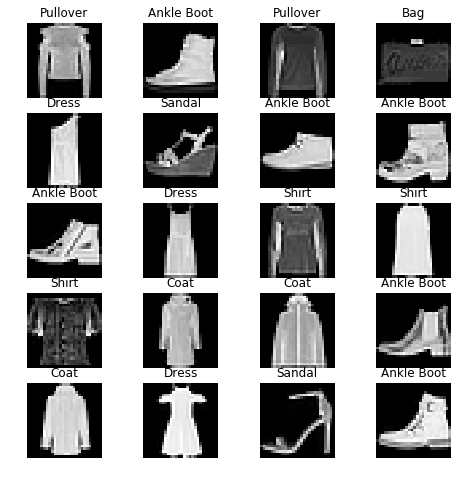

In [9]:
training_data = FashionMNIST(data_folder, train=True, download=True)

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(training_data));
    img = training_data[img_xy][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[training_data[img_xy][1].item()])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [17]:
print('Downloading and transforming data')
pre_process = transforms.Compose([
    transforms.ToTensor()
    ])

training_data = FashionMNIST(data_folder, train=True, download=True, transform=pre_process)
validation_data = FashionMNIST(data_folder, train=False, download=True, transform=pre_process)

training_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4)
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=4)


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [18]:
print('Starting training')
start_time = time.time()
network = CNN()
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

nbr_iterations = len(training_data)//batch_size
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(training_data_loader):
        images = Variable(images.float()).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad()
        outputs = network(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.data.item()
        losses.append(current_loss)
        
        if((i+1) % 100 == 0):
            print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i+1}/{nbr_iterations}, Loss: {round(current_loss, 2)}')
            
print(f'Done after {round((time.time() - start_time)/60, 2)}min')

Starting training
Done after 0.23min


In [61]:
network.eval()
correct = 0
total = 0
for images, labels in validation_data_loader:
    images = Variable(images.float())
    outputs = network(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print(f'Validation accuracy on 10 000 images: {round(correct.item()/total, 2)}')

Validation accuracy on 10 000 images: 90.54


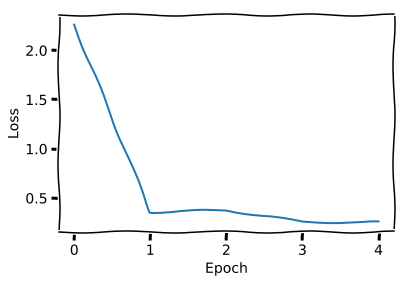

In [66]:
losses_in_epochs = losses[0::nbr_iterations]
plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()